# Preliminary Work

Let's check for multicollinearity and make sure to drop 1 dummy from each category.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy.stats import stats
import statsmodels.stats.api as sms

sns.set_style('darkgrid')

In [2]:
# importing data
df = pd.read_csv('csv_files/new_kc_house_data_clean_with_dummies2.csv')
df = df.drop(['Unnamed: 0','id'], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,yr_built,zipcode,lat,long,...,grd_12_to_13,jan_mar,apr_jun,jul_sep,oct_dec,cond_poor,cond_fair,cond_average,cond_good,cond_very_good
0,221900.0,3,1.00,1180,5650,1180,55,66,47.5112,-122.257,...,0,0,0,0,1,0,0,1,0,0
1,538000.0,3,2.25,2570,7242,2170,51,55,47.7210,-122.319,...,0,0,0,0,1,0,0,1,0,0
2,180000.0,2,1.00,770,10000,770,33,16,47.7379,-122.233,...,0,1,0,0,0,0,0,1,0,0
3,604000.0,4,3.00,1960,5000,1050,65,58,47.5208,-122.393,...,0,0,0,0,1,0,0,0,0,1
4,510000.0,3,2.00,1680,8080,1680,87,37,47.6168,-122.045,...,0,1,0,0,0,0,0,1,0,0


## Checking for Multicollinearity

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 44 columns):
price              21420 non-null float64
bedrooms           21420 non-null int64
bathrooms          21420 non-null float64
sqft_living        21420 non-null int64
sqft_lot           21420 non-null int64
sqft_above         21420 non-null int64
yr_built           21420 non-null int64
zipcode            21420 non-null int64
lat                21420 non-null float64
long               21420 non-null float64
sqft_living15      21420 non-null int64
sqft_lot15         21420 non-null int64
waterfront_N       21420 non-null int64
waterfront_Y       21420 non-null int64
not_renovated      21420 non-null int64
is_renovated       21420 non-null int64
floors_1           21420 non-null int64
floors_2           21420 non-null int64
floors_3           21420 non-null int64
floors_3_half      21420 non-null int64
not_viewed         21420 non-null int64
viewed             21420 non-null int64
day

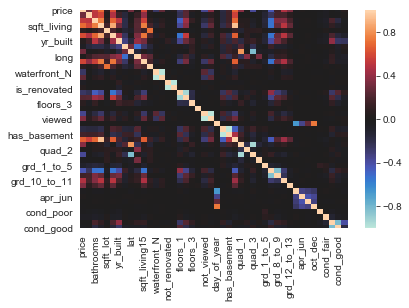

In [4]:
# checking heatmap for new correlations 
sns.heatmap(data=df.corr(), center=0)

In [5]:
# creating a date frame that only contains the pairs of values with highest 
# correlation

# converts all elements to absolute values, stacks into multi-index, resets 
# the index to set the multi-index to seperate columns, and finally sorts them
corr_pairs = df.corr().abs().stack().reset_index().sort_values(0, 
                                                                ascending=False)
# zipping the variable name columns
corr_pairs['pairs'] = list(zip(corr_pairs.level_0, corr_pairs.level_1))

#set index to the pairs
pairs_index = corr_pairs.set_index(['pairs'])

#dropping level columns
pairs = pairs_index.drop(columns=['level_0', 'level_1'])

#renaming column for comprehension
pairs.columns = ['correlation']
#Since our heatmap shows that our variables only show perfect correlation with 
#themselves, we'll drop duplicates
unique_pairs = pairs.drop_duplicates()

In [6]:
unique_pairs[(unique_pairs.correlation>0.75) & (unique_pairs.correlation<1)]

,correlation
pairs,
"(total_home_sqft, sqft_living)",0.941129
"(quad_3, quad_1)",0.934385
"(floors_2, floors_1)",0.929959
"(sqft_living, sqft_above)",0.876533
"(grd_8_to_9, grd_6_to_7)",0.836263
"(quad_3, lat)",0.826516
"(quad_1, lat)",0.821455
"(cond_average, cond_good)",0.813095
"(sqft_living15, sqft_living)",0.756186


In [7]:
# making a list of items to drop
to_drop = ['price','sqft_living','quad_3','floors_2','grd_8_to_9','cond_good',
           'has_basement','waterfront_N','not_viewed','jan_mar', 
           'not_renovated']

X = ['sqft_living','quad_3','floors_1','grd_8_to_9','cond_good',
           'no_basement','waterfront_N','not_viewed','jan_mar', 
           'not_renovated']

# Modeling

In [8]:
target = 'price'

feats = df.drop(to_drop, axis=1).columns
preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=df).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Ordinary least squares
=========================================================================================
Model:                     OLS                     Adj. R-squared:            0.726      
Dependent Variable:        price                   AIC:                       582102.4372
Date:                      2020-07-31 11:44        BIC:                       582373.4879
No. Observations:          21420                   Log-Likelihood:            -2.9102e+05
Df Model:                  33                      F-statistic:               1717.      
Df Residuals:              21386                   Prob (F-statistic):        0.00       
R-squared:                 0.726                   Scale:                     3.7074e+10 
-----------------------------------------------------------------------------------------
                    Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
-----------------------------------------------------------------------------------------
Intercept       -41436035.7497 2033483.9014 -20.3769 0.0000 -45421816.5391 -37450254.9604
bedrooms           -24768.1620    1856.2973 -13.3428 0.0000    -28406.6438    -21129.6802
bathrooms           46372.3801    3123.2196  14.8476 0.0000     40250.6357     52494.1245
sqft_lot                0.1456       0.0460   3.1683 0.0015         0.0555         0.2357
sqft_above            108.1922       4.3892  24.6498 0.0000        99.5891       116.7953
yr_built            -1865.9189      67.2610 -27.7415 0.0000     -1997.7555     -1734.0823
zipcode             -1586.8832      88.9459 -17.8410 0.0000     -1761.2238     -1412.5425
lat                174770.3230   18156.8824   9.6256 0.0000    139181.4731    210359.1728
long              -272343.6825   14707.2432 -18.5177 0.0000   -301170.9810   -243516.3839
sqft_living15          43.4919       3.3148  13.1206 0.0000        36.9947        49.9891
sqft_lot15             -0.3126       0.0703  -4.4456 0.0000        -0.4504        -0.1748
waterfront_Y       682860.7344   16615.0680  41.0989 0.0000    650293.9565    715427.5124
is_renovated        14082.3589    3254.9421   4.3265 0.0000      7702.4286     20462.2892
floors_1              828.7911    3599.7007   0.2302 0.8179     -6226.8919      7884.4741
floors_3            65157.5006    7641.2712   8.5270 0.0000     50180.0366     80134.9646
floors_3_half       88152.2996   72921.6702   1.2089 0.2267    -54779.6372    231084.2363
viewed             107451.0195    5012.1208  21.4382 0.0000     97626.8873    117275.1518
day_of_year          -123.1384      51.4055  -2.3954 0.0166      -223.8970       -22.3797
no_basement          2224.1234    5027.9031   0.4424 0.6582     -7630.9433     12079.1901
total_home_sqft        72.3653       2.9921  24.1857 0.0000        66.5006        78.2300
quad_1             176380.1044    5570.1713  31.6651 0.0000    165462.1513    187298.0576
quad_2             142878.6099   11404.1269  12.5287 0.0000    120525.6668    165231.5530
quad_4             188996.6437   14875.8452  12.7049 0.0000    159838.8727    218154.4147
grd_1_to_5         -73981.7899   12963.6189  -5.7069 0.0000    -99391.4541    -48572.1256
grd_6_to_7         -55305.8026    3666.6236 -15.0836 0.0000    -62492.6595    -48118.9457
grd_10_to_11       228459.0635    6388.5311  35.7608 0.0000    215937.0640    240981.0630
grd_12_to_13       935149.9187   21021.3826  44.4857 0.0000    893946.4339    976353.4036
apr_jun              8357.1042    5679.8209   1.4714 0.1412     -2775.7702     19489.9786
jul_sep              1438.6994    9681.6101   0.1486 0.8819    -17537.9818     20415.3806
oct_dec             11192.1137   14082.9384   0.7947 0.4268    -16411.5007     38795.7281
cond_poor         -113451.1853   36714.4955  -3.0901 0.0020   -185414.3469    -41488.0236
cond_fair          -43441.8412   15434.5337  -2.8146 0.0049    -73694.6835    -13188.9988
cond_average       -

In [9]:
# importing train_test_split
y = df['price']
x_cols = df.drop(to_drop, axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [10]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

14994 6426 14994 6426


In [11]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [12]:
#calculating the Mean Squared error
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 37604733134.94823
Test Mean Squarred Error: 35791980950.89742


In [13]:
# Caluclating Root Mean Squared Error
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 193919.39855246103
Test RMSE: 189187.68710171766


We've got a few things that aren't statistically significant, especially our variables for seasons.  Day of year, however, still has a low p-value, which is interesting.  Our Test RMSE is lower than our Training RMSE which is nice to see, but there is a bit of a difference between the two, in addition the overall RMSE being very large.

In [14]:
# dropping statistically insignificant features
to_drop = ['price','sqft_living','quad_3','floors_1','grd_8_to_9','cond_good',
           'no_basement','waterfront_N','not_viewed','jan_mar', 
           'not_renovated','floors_3_half','apr_jun','jul_sep','oct_dec']

X = ['sqft_living','quad_3','floors_1','grd_8_to_9','cond_good',
           'no_basement','waterfront_N','not_viewed','jan_mar', 
           'not_renovated','floors_3_half','apr_jun','jul_sep','oct_dec']

## Baseline Model

In [15]:

target = 'price'

feats = df.drop(to_drop, axis=1).columns
preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=df).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Ordinary least squares
=========================================================================================
Model:                     OLS                     Adj. R-squared:            0.725      
Dependent Variable:        price                   AIC:                       582104.5409
Date:                      2020-07-31 11:44        BIC:                       582343.7033
No. Observations:          21420                   Log-Likelihood:            -2.9102e+05
Df Model:                  29                      F-statistic:               1953.      
Df Residuals:              21390                   Prob (F-statistic):        0.00       
R-squared:                 0.726                   Scale:                     3.7085e+10 
-----------------------------------------------------------------------------------------
                    Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
-----------------------------------------------------------------------------------------
Intercept       -41502116.7015 2033015.0128 -20.4141 0.0000 -45486978.3920 -37517255.0110
bedrooms           -24740.2942    1856.4354 -13.3268 0.0000    -28379.0466    -21101.5417
bathrooms           46436.1176    3122.5774  14.8711 0.0000     40315.6321     52556.6031
sqft_lot                0.1450       0.0460   3.1562 0.0016         0.0550         0.2351
sqft_above            108.1324       4.3892  24.6361 0.0000        99.5292       116.7355
yr_built            -1865.8815      67.2660 -27.7389 0.0000     -1997.7279     -1734.0352
zipcode             -1583.7157      88.9443 -17.8057 0.0000     -1758.0532     -1409.3783
lat                174714.7865   18158.5472   9.6216 0.0000    139122.6739    210306.8990
long              -272940.1727   14705.3550 -18.5606 0.0000   -301763.7698   -244116.5756
sqft_living15          43.4198       3.3140  13.1018 0.0000        36.9240        49.9155
sqft_lot15             -0.3098       0.0703  -4.4058 0.0000        -0.4476        -0.1720
waterfront_Y       683217.9748   16616.6308  41.1165 0.0000    650648.1340    715787.8157
is_renovated        14007.6818    3255.1586   4.3032 0.0000      7627.3271     20388.0364
floors_2             -887.9421    3596.4258  -0.2469 0.8050     -7937.2062      6161.3219
floors_3            64036.1271    8113.5002   7.8925 0.0000     48133.0589     79939.1952
viewed             107319.8274    5012.0945  21.4122 0.0000     97495.7467    117143.9081
day_of_year           -99.5181      13.9418  -7.1381 0.0000      -126.8451       -72.1912
has_basement        -2251.9151    5027.8699  -0.4479 0.6542    -12106.9167      7603.0864
total_home_sqft        72.3835       2.9924  24.1888 0.0000        66.5181        78.2490
quad_1             176499.6703    5569.7920  31.6887 0.0000    165582.4608    187416.8798
quad_2             143059.9937   11404.9703  12.5437 0.0000    120705.3976    165414.5898
quad_4             189122.9987   14876.8506  12.7126 0.0000    159963.2573    218282.7402
grd_1_to_5         -73636.9153   12962.9692  -5.6806 0.0000    -99045.3059    -48228.5248
grd_6_to_7         -55409.6260    3665.6664 -15.1158 0.0000    -62594.6068    -48224.6452
grd_10_to_11       228678.2022    6388.4981  35.7953 0.0000    216156.2676    241200.1369
grd_12_to_13       935716.3983   21012.7591  44.5309 0.0000    894529.8167    976902.9799
cond_poor         -113058.3304   36716.9392  -3.0792 0.0021   -185026.2812    -41090.3796
cond_fair          -43342.4561   15431.8144  -2.8086 0.0050    -73589.9680    -13094.9441
cond_average       -28589.7431    3334.6867  -8.5734 0.0000    -35125.9787    -22053.5075
cond_very_good      38248.4915    5430.3242   7.0435 0.0000     27604.6493     48892.3336
-----------------------------------------------------------------------------------------
Omnibus:                    15999.497            Durbin-Watson:               1.993      
Prob(Omnibus):      

Adjusted R-squared has dropped, but not by much. So we'll call this our baseline model. Let's check the change in RMSE and move on to tightening it up.

In [16]:
y = df['price']
x_cols = df.drop(to_drop, axis=1)

X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [17]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [18]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 37630656073.651924
Test Mean Squarred Error: 35755698658.74377


In [19]:
# Caluclating Root Mean Squared Error
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 193986.2265050071
Test RMSE: 189091.77311227415


Those values, were very insignificant, because there is little to no change in RMSE and overall fit.

Now lets look at the QQ-plot and checking for homoscedasticity 

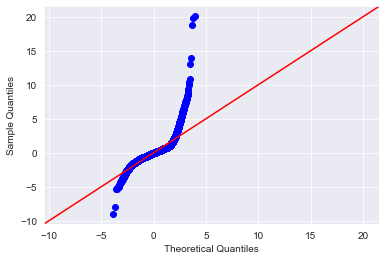

In [20]:
# Checking distribution  of errors using QQ-plot
fig = sm.graphics.qqplot(model.resid, dist='norm', line='45', fit=True)

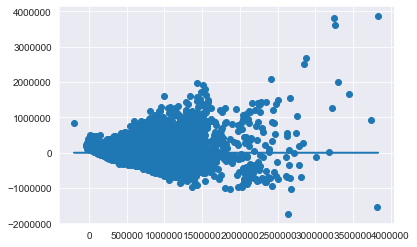

In [21]:
# Checking for homoscedasticity 

X = df.drop(to_drop, axis=1)

plt.scatter(model.predict(X), model.resid)
plt.plot(model.predict(X), [0 for i in range(len(df))])

Plot shows signs of **heteroscedasticity**. Residual errors are **not distributed normally**.

In [22]:
df1 = df.copy()

In [23]:
# before we go further, we'll create a new data frame with all of the 
# insignificant values removed
X = ['sqft_living','quad_3','floors_1','grd_8_to_9','cond_good',
           'no_basement','waterfront_N','not_viewed','jan_mar', 
           'not_renovated','floors_3_half','apr_jun','jul_sep','oct_dec']

df1 = df1.drop(X, axis=1)

# Outliers

As we saw earlier, not only are our residuals not normal, but there are a lot of outliers. Lets trim them down.

In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 30 columns):
price              21420 non-null float64
bedrooms           21420 non-null int64
bathrooms          21420 non-null float64
sqft_lot           21420 non-null int64
sqft_above         21420 non-null int64
yr_built           21420 non-null int64
zipcode            21420 non-null int64
lat                21420 non-null float64
long               21420 non-null float64
sqft_living15      21420 non-null int64
sqft_lot15         21420 non-null int64
waterfront_Y       21420 non-null int64
is_renovated       21420 non-null int64
floors_2           21420 non-null int64
floors_3           21420 non-null int64
viewed             21420 non-null int64
day_of_year        21420 non-null int64
has_basement       21420 non-null int64
total_home_sqft    21420 non-null float64
quad_1             21420 non-null int64
quad_2             21420 non-null int64
quad_4             21420 non-null int64
g

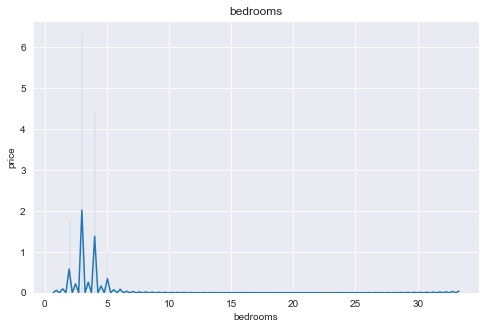

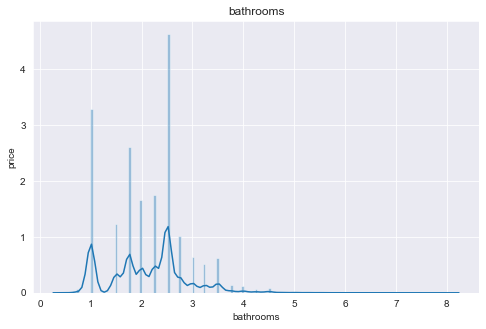

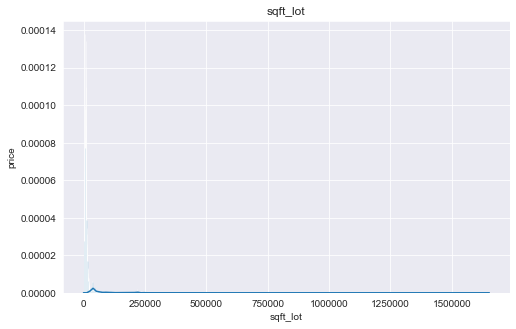

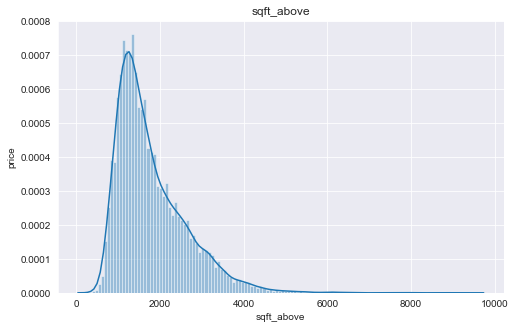

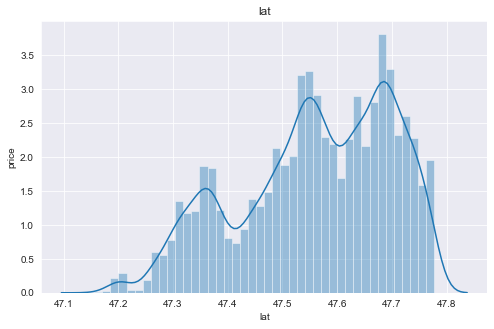

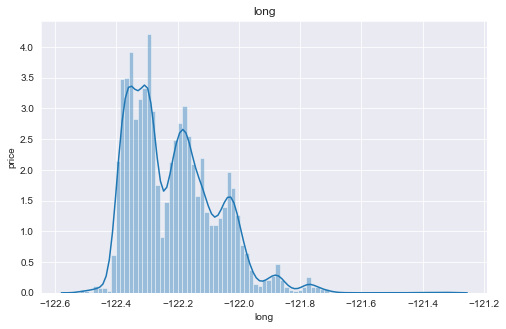

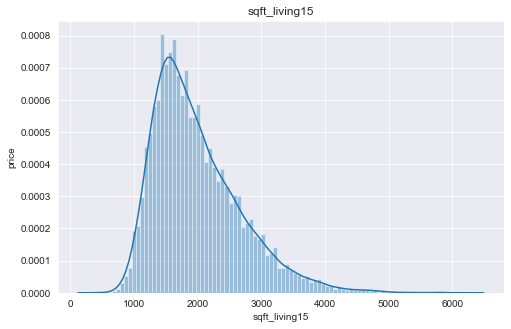

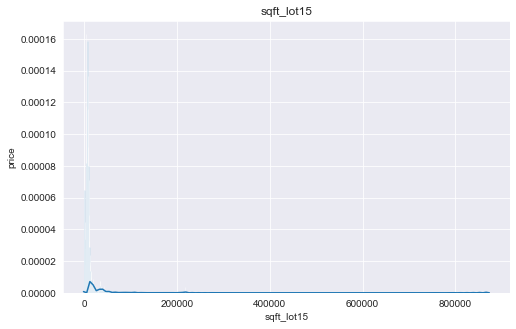

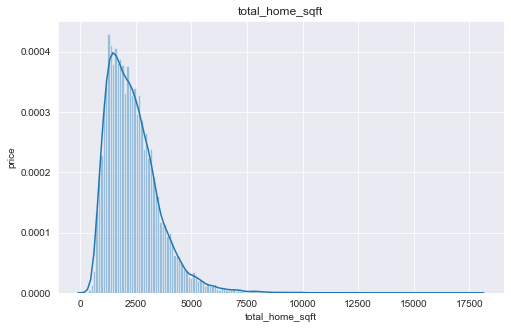

In [25]:
# We'll use a joint plot so we can also see the distribution of each feature
# as well as their relationship to the target
conts = df1[['price','bedrooms','bathrooms','sqft_lot','sqft_above','lat',
             'long','sqft_living15','sqft_lot15','total_home_sqft']]

no_price = conts.drop('price', axis=1)

for col in no_price.columns:
    plt.figure(figsize=(8,5))
    sns.distplot(conts[col], bins='auto')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('price')
    plt.show()

Identified the features to work on, so let's get to removing outliers

## Bedrooms

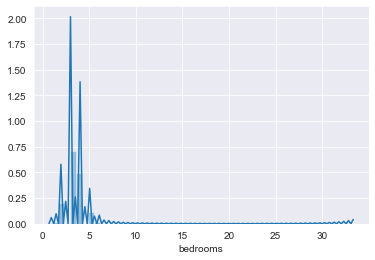

In [26]:
sns.distplot(df1['bedrooms'], kde=True)

In [27]:
# checking value counts
df1.bedrooms.value_counts()

3     9731
4     6849
2     2736
5     1586
6      265
1      191
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [28]:
# checking out the stats of these houses that have 10 or more bedrooms
# Calling original data frame, before data was normalized 
mansion = df[df['bedrooms'] >= 10]
mansion.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,yr_built,zipcode,lat,long,...,grd_12_to_13,jan_mar,apr_jun,jul_sep,oct_dec,cond_poor,cond_fair,cond_average,cond_good,cond_very_good
8679,520000.0,11,3.00,3000,4960,2400,18,44,47.5560,-122.363,...,0,0,0,1,0,0,0,1,0,0
13182,1150000.0,10,5.25,4590,10920,2500,108,3,47.5861,-122.113,...,0,0,0,1,0,0,0,1,0,0
15011,650000.0,10,2.00,3610,11914,3010,58,5,47.5705,-122.175,...,0,0,0,0,1,0,0,0,1,0
15710,640000.0,33,1.75,1620,6000,1040,47,42,47.6878,-122.331,...,0,0,1,0,0,0,0,0,0,1
19070,660000.0,10,3.00,2920,3745,1860,13,43,47.6635,-122.320,...,0,0,0,0,1,0,0,0,1,0


### Notes:
* The house with 33 bedrooms is clearly a **clerical error**.  A house with that is 2000 sq. ft. (with the basement) **cannot** have 33 bedrooms and 1.75 bathrooms.  The most likely explanation is human error and that this is actually a 3 bedroom home. As this is only a hypothesis, however, we'll just eliminate it along with anything else that has a z-score greater than 3. 

In [29]:
# using z-score to eliminate outliers 
df2 = df1.copy()
z = np.abs(stats.zscore(df2.bedrooms))
threshold = 3
df2 = df2[(z < 3)]

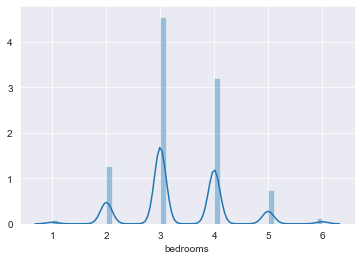

In [30]:
sns.distplot(df2['bedrooms'], label=col, kde=True)

Even though bedrooms can be considered continuous (a house can have as many rooms as the architect wants), you can make the argument that you can categorize houses by the number of bedrooms they have.  We'll change this to categorical.

In [31]:
# Changing to categorical
df2['bedrooms'] = df2['bedrooms'].astype('category')
df2['bedrooms'] = df2.bedrooms.cat.codes

## Bathrooms

2.50    5349
1.00    3793
1.75    3019
2.25    2028
2.00    1912
1.50    1427
2.75    1176
3.00     738
3.50     723
3.25     584
3.75     152
4.00     126
4.50      94
4.25      77
0.75      70
4.75      21
5.00      20
5.25      12
5.50       9
1.25       9
6.00       5
0.50       4
5.75       3
6.25       2
6.50       2
8.00       1
7.75       1
6.75       1
Name: bathrooms, dtype: int64

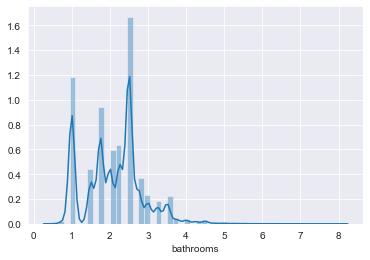

In [32]:
sns.distplot(df2['bathrooms'], label=col, kde=True)
df2.bathrooms.value_counts()

In [33]:
# We'll just do some trimming
df2 = df2[df2['bathrooms'] <= 4.00]

2.50    5349
1.00    3793
1.75    3019
2.25    2028
2.00    1912
1.50    1427
2.75    1176
3.00     738
3.50     723
3.25     584
3.75     152
4.00     126
0.75      70
1.25       9
0.50       4
Name: bathrooms, dtype: int64

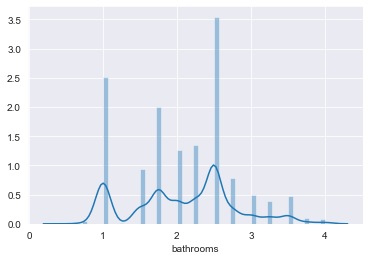

In [34]:
sns.distplot(df2['bathrooms'], label=col, kde=True)
df2.bathrooms.value_counts()

In [35]:
# Changing to categorical
df2['bathrooms'] = df2['bathrooms'].astype('category')
df2['bathrooms'] = df2.bathrooms.cat.codes

## Total_home_sqft

count    21110.000000
mean      2322.399526
std       1090.115409
min        370.000000
25%       1490.000000
50%       2150.000000
75%       2940.000000
max      10500.000000
Name: total_home_sqft, dtype: float64

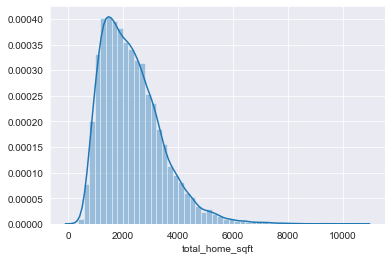

In [36]:
sns.distplot(df2['total_home_sqft'], label=col, kde=True)
df2.total_home_sqft.describe()

In [37]:
# We'll use the z-score again, but this data is pretty normal (thankfully)
z = np.abs(stats.zscore(df2.total_home_sqft))
threshold = 3
df2 = df2[(z < 3)]

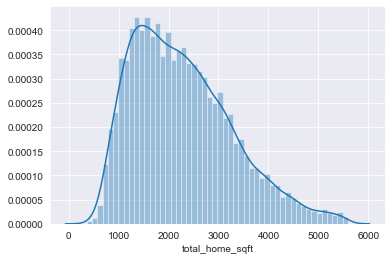

In [38]:
sns.distplot(df2['total_home_sqft'], label=col, kde=True)

## Sqft_lot

array([ 5650,  7242, 10000, ...,  5813,  2388,  1076], dtype=int64)

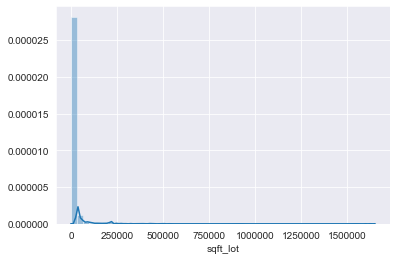

In [39]:
sns.distplot(df2['sqft_lot'], label=col, kde=True)
df2.sqft_lot.unique()

In [40]:
z = np.abs(stats.zscore(df2.sqft_lot))
threshold = 3
df2 = df2[(z < 3)]

It's a marked improvement, but if this graph represents 3 standard deviations, it might be worth dropping entirely

## Sqft_lot15

count     20562.000000
mean      10317.830902
std       15650.489569
min         651.000000
25%        5038.000000
50%        7508.000000
75%        9826.750000
max      434728.000000
Name: sqft_lot15, dtype: float64

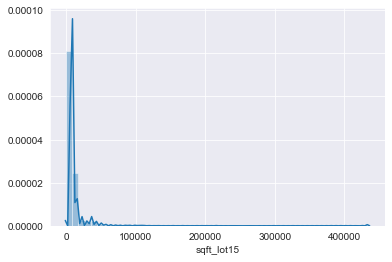

In [41]:
sns.distplot(df2['sqft_lot15'], label=col, kde=True)
df2.sqft_lot15.describe()

In [42]:
z = np.abs(stats.zscore(df2.sqft_lot15))
threshold = 3
df2 = df2[(z < 3)]

count    20287.000000
mean      8965.116133
std       7657.387711
min        651.000000
25%       5000.000000
50%       7500.000000
75%       9724.000000
max      57140.000000
Name: sqft_lot15, dtype: float64

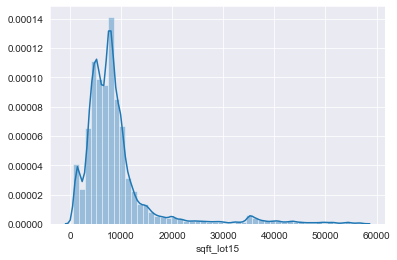

In [43]:
sns.distplot(df2['sqft_lot15'], label=col, kde=True)
df2.sqft_lot15.describe()

## Log Transformation

These plots still look pretty non-normal, so let's perform a log transformation and see if we can improve this.

In [44]:
# creating a new data frame for the log transformations
# bedrooms and 
log_df = df2.copy()
log_df = log_df.rename({'sqft_lot': 'log_sqft_lot',
                     'sqft_above':'log_sqft_above',
                     'total_home_sqft':'log_total_home_sqft',
                      'sqft_living15':'log_sqft_living15',
                      'sqft_lot15':'log_sqft_lot15'}, axis=1)

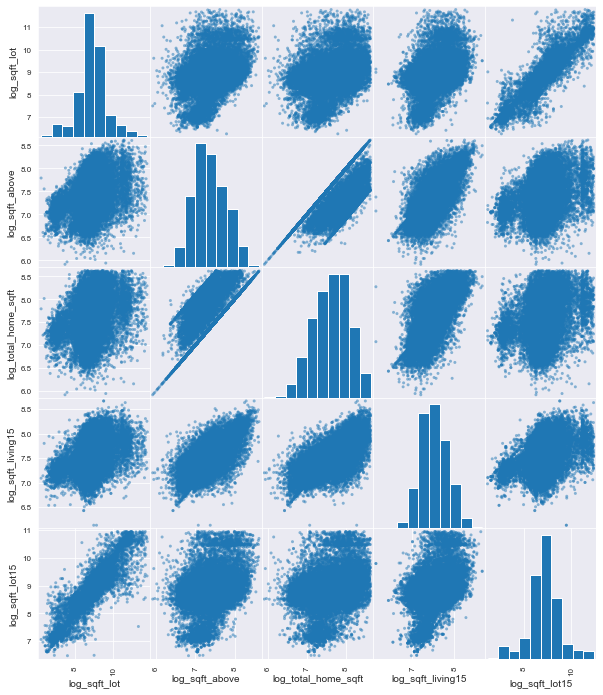

In [45]:
#transforming 
revised_logs = ['log_sqft_lot','log_sqft_above','log_total_home_sqft',
                'log_sqft_living15','log_sqft_lot15']

for log in revised_logs:
    log_df[log] = log_df[log].map(lambda x : np.log(x))
    log_df[log] = log_df[log].rename({log : 'log_'+log})
pd.plotting.scatter_matrix(log_df[revised_logs], figsize=(10,12));

In [46]:
conts = ['log_sqft_lot','log_sqft_above','log_total_home_sqft',
                'log_sqft_living15','log_sqft_lot15']

In [47]:
def norm_feat(series):
    """
    Input a series containing continuous variables.
    Outputs a normalized version of the data
    """
    return (series - series.mean())/series.std()

for feat in conts:
    log_df[feat] = norm_feat(log_df[feat])

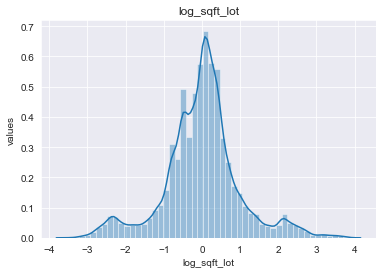

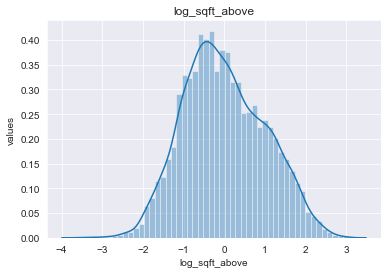

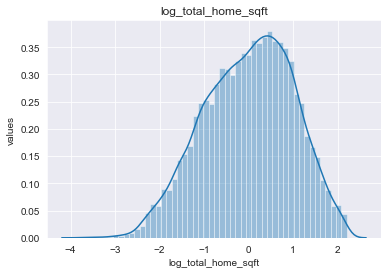

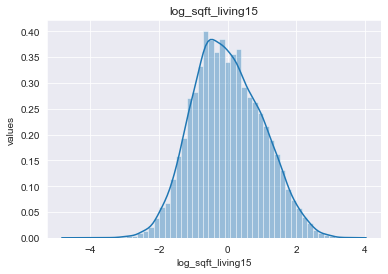

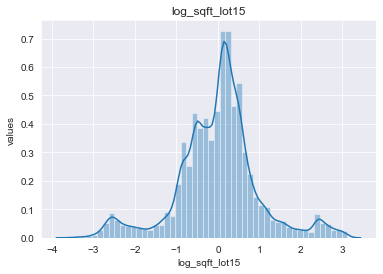

In [48]:
for col in conts: 
    sns.distplot(log_df[col], label=[col])
    plt.xlabel(col)
    plt.ylabel('values')
    plt.title(col)
    plt.show()

They look...interesting...but let's model it and calculate the RMSE.

In [49]:
target = 'price'

feats = log_df.drop('price', axis=1).columns
preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=log_df).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Ordinary least squares
=============================================================================================
Model:                       OLS                      Adj. R-squared:             0.693      
Dependent Variable:          price                    AIC:                        544901.4733
Date:                        2020-07-31 11:44         BIC:                        545139.0054
No. Observations:            20287                    Log-Likelihood:             -2.7242e+05
Df Model:                    29                       F-statistic:                1580.      
Df Residuals:                20257                    Prob (F-statistic):         0.00       
R-squared:                   0.693                    Scale:                      2.7032e+10 
---------------------------------------------------------------------------------------------
                        Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
---------------------------------------------------------------------------------------------
Intercept           -31534658.7546 1822873.2188 -17.2994 0.0000 -35107638.0986 -27961679.4105
bedrooms               -12148.8950    1821.6594  -6.6691 0.0000    -15719.4952     -8578.2949
bathrooms               10722.5783     733.2815  14.6227 0.0000      9285.2871     12159.8695
log_sqft_lot            -2160.3294    2939.8468  -0.7348 0.4624     -7922.6675      3602.0087
log_sqft_above          90300.1468    3604.9305  25.0491 0.0000     83234.1907     97366.1028
yr_built                -1889.8420      60.4048 -31.2863 0.0000     -2008.2403     -1771.4437
zipcode                 -1203.2916      78.3278 -15.3623 0.0000     -1356.8204     -1049.7628
lat                    167522.1479   16133.3049  10.3836 0.0000    135899.5619    199144.7339
long                  -197364.2634   13364.9467 -14.7673 0.0000   -223560.6428   -171167.8839
log_sqft_living15       41826.2000    1955.8202  21.3855 0.0000     37992.6338     45659.7662
log_sqft_lot15          -7991.2744    2880.1979  -2.7746 0.0055    -13636.6959     -2345.8530
waterfront_Y           590210.0628   16524.7014  35.7168 0.0000    557820.3078    622599.8177
is_renovated            15858.4365    2855.6056   5.5534 0.0000     10261.2180     21455.6549
floors_2                -8707.2899    3466.0998  -2.5121 0.0120    -15501.1266     -1913.4531
floors_3                25197.3108    7726.2273   3.2613 0.0011     10053.2788     40341.3428
viewed                 112819.0770    4536.0780  24.8715 0.0000    103927.9964    121710.1577
day_of_year              -104.0484      12.2273  -8.5095 0.0000      -128.0148       -80.0819
has_basement            45688.2856    5386.7647   8.4816 0.0000     35129.7900     56246.7812
log_total_home_sqft     13733.7120    3639.0615   3.7740 0.0002      6600.8564     20866.5676
quad_1                 175281.2796    5007.5826  35.0032 0.0000    165466.0116    185096.5475
quad_2                 138920.3228   10509.7751  13.2182 0.0000    118320.3112    159520.3344
quad_4                 180682.1800   13870.9263  13.0260 0.0000    153494.0394    207870.3206
grd_1_to_5             -60291.9005   11629.0595  -5.1846 0.0000    -83085.8002    -37498.0009
grd_6_to_7             -73211.4888    3266.7128 -22.4114 0.0000    -79614.5109    -66808.4668
grd_10_to_11           280614.8119    5679.9444  49.4045 0.0000    269481.6602    291747.9636
grd_12_to_13           713631.5626   27836.0797  25.6369 0.0000    659070.5888    768192.5363
cond_poor             -101762.8382   31963.9448  -3.1837 0.0015   -164414.7623    -39110.9141
cond_fair              -45107.9359   13924.6788  -3.2394 0.0012    -72401.4357    -17814.4362
cond_average           -29834.5039    2933.7533 -10.1694 0.0000    -35584.8983    -24084.1095
cond_very_good          42417.8892    4756.0120   8.9188 0.0000     33095.7200     51740.0585
----------------------------------

In [50]:
y = log_df['price']
x_cols = log_df.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [51]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [52]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 27486559078.4302
Test Mean Squarred Error: 25905564991.08809


In [53]:
# Caluclating Root Mean Squared Error
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 165790.70866134265
Test RMSE: 160952.05805173193


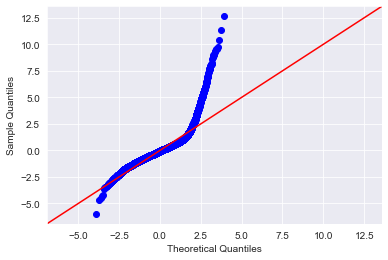

In [54]:
# Checking distribution  of errors using QQ-plot
fig = sm.graphics.qqplot(model.resid, dist='norm', line='45', fit=True)

### Initial Analysis

So far we can see that the RMSE for both the test and training data sets are relatively close.  So we know that so far, the model (despite its flaws) is not over trained.  It still has an root mean squared error of 165,000.  This isn't great, but it is not horrible in context. Given the price range of the data we're dealing with (between 78,000-3.4 million), being off by 165,000 isn't too bad on the higher end of the spectrum.  It does make it a poor estimator of lower prices.  This is could be due to the fact that there was still great deal of outliers in our residual errors, even after trimming them down. It could also be due to the fact that the residuals also don't follow a normal distribution.  

Before we commit to this, let's see if we can improve our model any further through step-wise selection.

# Step-Wise Selection

In [55]:
# Using step-wise selection to eliminate any remaining statistically 
# insignificant features based on their p-values

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [56]:
features = log_df.drop('price', axis=1)

result = stepwise_selection(features, log_df['price'], verbose=True)
print('resulting features:')
print(result)

Add  log_total_home_sqft            with p-value 0.0
Add  grd_6_to_7                     with p-value 0.0
Add  grd_10_to_11                   with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  quad_1                         with p-value 0.0
Add  waterfront_Y                   with p-value 0.0
Add  log_sqft_above                 with p-value 0.0
Add  viewed                         with p-value 1.01174e-187
Add  grd_12_to_13                   with p-value 1.23287e-144
Add  log_sqft_living15              with p-value 3.15881e-70
Add  bathrooms                      with p-value 1.89825e-67
Add  cond_average                   with p-value 1.80125e-31
Add  quad_2                         with p-value 4.3938e-25
Add  has_basement                   with p-value 1.49301e-23
Add  long                           with p-value 9.53689e-19
Add  quad_4                         with p-value 1.15057e-34
Add  zipcode                        with p-value 3.33975e-35
Add  lat          

In [57]:
# lets see what results we get when we use these suggested features

suggested = log_df[['price','grd_6_to_7', 'grd_10_to_11', 'quad_1', 'log_sqft_above', 
                 'has_basement', 'waterfront_Y', 'yr_built', 'viewed', 
                 'grd_12_to_13', 'log_sqft_living15', 'bathrooms', 
                 'cond_average', 'lat', 'log_sqft_lot15', 'zipcode', 
                 'cond_very_good', 'day_of_year', 'long', 'quad_4', 'quad_2', 
                 'grd_1_to_5', 'bedrooms', 'is_renovated', 'floors_2', 
                 'log_total_home_sqft', 'floors_3', 'cond_fair', 'cond_poor']]

target = 'price'

feats = suggested.drop(['price'], axis=1).columns
preds = '+'.join(feats)

formula2 = target + '~' + preds
model2 = smf.ols(formula=formula2, data=log_df).fit()
model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Ordinary least squares
=============================================================================================
Model:                       OLS                      Adj. R-squared:             0.693      
Dependent Variable:          price                    AIC:                        544900.0141
Date:                        2020-07-31 11:45         BIC:                        545129.6284
No. Observations:            20287                    Log-Likelihood:             -2.7242e+05
Df Model:                    28                       F-statistic:                1636.      
Df Residuals:                20258                    Prob (F-statistic):         0.00       
R-squared:                   0.693                    Scale:                      2.7031e+10 
---------------------------------------------------------------------------------------------
                        Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
---------------------------------------------------------------------------------------------
Intercept           -31621820.4667 1818989.4756 -17.3843 0.0000 -35187187.3486 -28056453.5848
grd_6_to_7             -73277.3298    3265.4468 -22.4402 0.0000    -79677.8702    -66876.7893
grd_10_to_11           280566.3859    5679.4976  49.3999 0.0000    269434.1100    291698.6619
quad_1                 175496.0330    4998.9909  35.1063 0.0000    165697.6055    185294.4604
log_sqft_above          90035.5066    3586.8562  25.1015 0.0000     83004.9776     97066.0355
has_basement            45770.2173    5385.5495   8.4987 0.0000     35214.1034     56326.3311
waterfront_Y           590153.9582   16524.3374  35.7142 0.0000    557764.9168    622542.9996
yr_built                -1883.9695      59.8732 -31.4660 0.0000     -2001.3258     -1766.6133
viewed                 112746.7198    4534.9576  24.8617 0.0000    103857.8351    121635.6046
grd_12_to_13           713603.7676   27835.7380  25.6362 0.0000    659043.4638    768164.0713
log_sqft_living15       41876.1424    1954.6168  21.4242 0.0000     38044.9350     45707.3499
bathrooms               10741.0152     732.8438  14.6566 0.0000      9304.5819     12177.4486
cond_average           -29861.6975    2933.4866 -10.1796 0.0000    -35611.5691    -24111.8259
lat                    167273.7283   16129.5796  10.3706 0.0000    135658.4443    198889.0122
log_sqft_lot15          -9742.6546    1617.1560  -6.0246 0.0000    -12912.4115     -6572.8976
zipcode                 -1201.6421      78.2947 -15.3477 0.0000     -1355.1061     -1048.1781
cond_very_good          42492.8789    4754.8631   8.9367 0.0000     33172.9617     51812.7962
day_of_year              -104.1259      12.2267  -8.5163 0.0000      -128.0912       -80.1606
long                  -198167.0840   13320.0678 -14.8773 0.0000   -224275.4970   -172058.6710
quad_4                 180976.1818   13864.9978  13.0527 0.0000    153799.6618    208152.7017
quad_2                 139169.4839   10504.1850  13.2490 0.0000    118580.4296    159758.5383
grd_1_to_5             -60460.8288   11626.6551  -5.2002 0.0000    -83250.0156    -37671.6420
bedrooms               -12167.1680    1821.4690  -6.6799 0.0000    -15737.3949     -8596.9410
is_renovated            15873.4356    2855.5002   5.5589 0.0000     10276.4237     21470.4476
floors_2                -8332.6068    3428.3528  -2.4305 0.0151    -15052.4562     -1612.7574
log_total_home_sqft     13606.5446    3634.9031   3.7433 0.0002      6481.8397     20731.2495
floors_3                25908.3541    7665.3103   3.3799 0.0007     10883.7242     40932.9839
cond_fair              -45501.2154   13914.2322  -3.2701 0.0011    -72774.2389    -18228.1919
cond_poor             -102657.9686   31940.3628  -3.2141 0.0013   -165263.6699    -40052.2672
---------------------------------------------------------------------------------------------
Omnibus:                     11309

In [58]:
x_cols = suggested.drop(['price'], axis=1)
y = log_df['price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [59]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [60]:
#calculating the Mean Squared error
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 27487613616.02448
Test Mean Squarred Error: 25905525696.582256


In [61]:
# Caluclating Root Mean Squared Error
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 165793.8889586238
Test RMSE: 160951.93598270963


### Results
Well, there is no difference in the RMSE by using Step-wise Selection. Even though Step-wise gave us a better adjusted R-squared. It did remove one feature, making our model a slightly less complex. Let's keep this for now and move on.

## Cross Validation

In [62]:
df3 = suggested.copy()

In [63]:
# cross validating our model for consistency
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

x_cols = df3.drop(['price'], axis=1)
y = df3['price']

cv_5_results  = np.mean(cross_val_score(linreg, x_cols, y, cv=5,  
                                        scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, x_cols, y, cv=10, 
                                        scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, x_cols, y, cv=20, 
                                        scoring='neg_mean_squared_error'))

In [64]:
print("Mean CV 5 results: ", cv_5_results.mean())
print("Mean CV 10 results: ", cv_10_results.mean())
print("Mean CV 20 results: ", cv_20_results.mean())
print('Train MSE: ', train_mse)
print('Test MSE: ',test_mse )

Mean CV 5 results:  -27308140484.688484
Mean CV 10 results:  -27257298458.329853
Mean CV 20 results:  -27181916700.0142
Train MSE:  27487613616.02448
Test MSE:  25905525696.582256


By comparison, the difference between the Cross Validation means and our MSE values are close, but not close enough. Let's go ahead and see if we can tighten up these values by including interactions.

In [65]:
# for easy reference, we'll calculate our baseline r-squared 

from sklearn.model_selection import KFold

regression = LinearRegression()

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=42)
baseline_r_sqr = np.mean(cross_val_score(regression, x_cols, y, scoring='r2', 
                                   cv=crossvalidation))

baseline_r_sqr

0.691746859013687

# Interactions
Let's see if we can improve our model fit any more and lower our RMSE by including interactions.

In [66]:
features = df3.drop('price', axis=1)

In [67]:
from itertools import combinations

interactions = []

feat_combinations = combinations(features.columns, 2)

data = features.copy()

# for loop that takes a copy of our data frame, retrieves the columns and 
# multiplies them together, evaluates the mean of the cross-validation of the 
# model with the interactions present.  If the score is greater than the 
# baseline it will be added to the list of interactions, with their score

for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', 
                                    cv=crossvalidation))
    if score > baseline_r_sqr:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 3 interactions: %s' %sorted(interactions, 
                                       key=lambda inter: inter[2], 
                                       reverse=True)[:3])

0
50
100
150
200
250
300
350
Top 3 interactions: [('log_sqft_above', 'log_total_home_sqft', 0.706), ('bathrooms', 'log_total_home_sqft', 0.704), ('quad_1', 'log_sqft_above', 0.703)]


## Adding Interactions

In [68]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

final = df3.copy()

final['log_sqft_above*log_total_home_sqft'] = (final['log_sqft_above'] * 
                                               final['log_total_home_sqft'])

final['bathrooms*log_total_home_sqft'] = (final['bathrooms'] * 
                                          final['log_total_home_sqft'])

final['quad_1*log_sqft_above'] = final['quad_1'] * final['log_sqft_above']

fin_x = final.drop('price', axis=1)

final_model = np.mean(cross_val_score(regression, fin_x, y, scoring='r2', cv=crossvalidation))

final_model

0.7176352645761447

Ok, our R-squared went up, so let's test this out.

## Applying to Model

In [69]:
target = 'price'

feats = fin_x.columns

preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=final).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Ordinary least squares
============================================================================================================
Model:                            OLS                           Adj. R-squared:                  0.718      
Dependent Variable:               price                         AIC:                             543143.9644
Date:                             2020-07-31 11:46              BIC:                             543397.3320
No. Observations:                 20287                         Log-Likelihood:                  -2.7154e+05
Df Model:                         31                            F-statistic:                     1671.      
Df Residuals:                     20255                         Prob (F-statistic):              0.00       
R-squared:                        0.719                         Scale:                           2.4786e+10 
------------------------------------------------------------------------------------------------------------
                                       Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
------------------------------------------------------------------------------------------------------------
Intercept                          -34835498.2602 1746694.8215 -19.9437 0.0000 -38259161.7877 -31411834.7326
grd_6_to_7                            -66868.1261    3133.1741 -21.3420 0.0000    -73009.4015    -60726.8508
grd_10_to_11                          192956.2741    5852.5369  32.9697 0.0000    181484.8271    204427.7211
quad_1                                169263.4763    4804.6267  35.2293 0.0000    159846.0183    178680.9343
log_sqft_above                         18801.2688    4071.2495   4.6181 0.0000     10821.2895     26781.2481
has_basement                           23291.6771    5203.4136   4.4762 0.0000     13092.5644     33490.7898
waterfront_Y                          591860.5381   15823.7341  37.4033 0.0000    560844.7357    622876.3405
yr_built                               -1708.6143      58.0152 -29.4512 0.0000     -1822.3287     -1594.8999
viewed                                101949.1517    4354.8414  23.4105 0.0000     93413.3093    110484.9941
grd_12_to_13                          530011.2706   27067.9673  19.5808 0.0000    476955.8592    583066.6820
log_sqft_living15                      43608.0681    1886.4331  23.1167 0.0000     39910.5063     47305.6300
bathrooms                               8473.8067     711.5906  11.9083 0.0000      7079.0314      9868.5820
cond_average                          -30996.9537    2813.6868 -11.0165 0.0000    -36512.0080    -25481.8994
lat                                   160133.7344   15498.4933  10.3322 0.0000    129755.4304    190512.0385
log_sqft_lot15                        -17748.1342    1560.3664 -11.3743 0.0000    -20806.5788    -14689.6895
zipcode                                -1305.1864      75.2487 -17.3450 0.0000     -1452.6800     -1157.6929
cond_very_good                         38910.4819    4554.0129   8.5442 0.0000     29984.2472     47836.7166
day_of_year                             -104.7801      11.7089  -8.9488 0.0000      -127.7305       -81.8298
long                                 -227213.5242   12839.0488 -17.6971 0.0000   -252379.1012   -202047.9473
quad_4                                204211.5636   13307.8428  15.3452 0.0000    178127.1123    230296.0149
quad_2                                164978.9968   10237.0962  16.1158 0.0000    144913.4579    185044.5358
grd_1_to_5                           -164136.5954   11458.0023 -14.3251 0.0000   -186595.2094   -141677.9814
bedrooms                              -14072.2043    1753.6455  -8.0245 0.0000    -17509.4917    -10634.9168
is_renovated                           15956.1127    2734.3658   5.8354 0.0000     10596.5339     21315.6916
floors_2                                1774.6895    3311.6191   0

### Calculating RMSE 

In [70]:
x_cols = fin_x
y = final['price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [71]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [72]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 25091574505.04287
Test Mean Squarred Error: 24009159523.77145


In [73]:
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 158403.20231940664
Test RMSE: 154948.89326410645


RMSE has improved a good amount! Let's cross validate it!

# Cross-Validating Final Model

In [74]:
x_cols = fin_x
y = final['price']

cv_5_results  = np.mean(cross_val_score(linreg, x_cols, y, cv=5,  
                                        scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, x_cols, y, cv=10, 
                                        scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, x_cols, y, cv=20, 
                                        scoring='neg_mean_squared_error'))

In [75]:
print("Root Mean CV 5 results: ", np.sqrt(abs(cv_5_results.mean())))
print("Root CV 10 results: ", np.sqrt(abs(cv_10_results.mean())))
print("Root CV 20 results: ", np.sqrt(abs(cv_20_results.mean())))
print('Train RMSE: ', train_rmse)
print('Test RMSE: ',test_rmse)

Root Mean CV 5 results:  158108.85709646254
Root CV 10 results:  158014.54058759604
Root CV 20 results:  157867.17398846796
Train RMSE:  158403.20231940664
Test RMSE:  154948.89326410645


## Results:
These results look pretty good considering where we have come from! Let's take a look at our model and its QQ-plot one last time.

In [76]:
target = 'price'

feats = fin_x.columns

preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=final).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Ordinary least squares
============================================================================================================
Model:                            OLS                           Adj. R-squared:                  0.718      
Dependent Variable:               price                         AIC:                             543143.9644
Date:                             2020-07-31 11:46              BIC:                             543397.3320
No. Observations:                 20287                         Log-Likelihood:                  -2.7154e+05
Df Model:                         31                            F-statistic:                     1671.      
Df Residuals:                     20255                         Prob (F-statistic):              0.00       
R-squared:                        0.719                         Scale:                           2.4786e+10 
------------------------------------------------------------------------------------------------------------
                                       Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
------------------------------------------------------------------------------------------------------------
Intercept                          -34835498.2602 1746694.8215 -19.9437 0.0000 -38259161.7877 -31411834.7326
grd_6_to_7                            -66868.1261    3133.1741 -21.3420 0.0000    -73009.4015    -60726.8508
grd_10_to_11                          192956.2741    5852.5369  32.9697 0.0000    181484.8271    204427.7211
quad_1                                169263.4763    4804.6267  35.2293 0.0000    159846.0183    178680.9343
log_sqft_above                         18801.2688    4071.2495   4.6181 0.0000     10821.2895     26781.2481
has_basement                           23291.6771    5203.4136   4.4762 0.0000     13092.5644     33490.7898
waterfront_Y                          591860.5381   15823.7341  37.4033 0.0000    560844.7357    622876.3405
yr_built                               -1708.6143      58.0152 -29.4512 0.0000     -1822.3287     -1594.8999
viewed                                101949.1517    4354.8414  23.4105 0.0000     93413.3093    110484.9941
grd_12_to_13                          530011.2706   27067.9673  19.5808 0.0000    476955.8592    583066.6820
log_sqft_living15                      43608.0681    1886.4331  23.1167 0.0000     39910.5063     47305.6300
bathrooms                               8473.8067     711.5906  11.9083 0.0000      7079.0314      9868.5820
cond_average                          -30996.9537    2813.6868 -11.0165 0.0000    -36512.0080    -25481.8994
lat                                   160133.7344   15498.4933  10.3322 0.0000    129755.4304    190512.0385
log_sqft_lot15                        -17748.1342    1560.3664 -11.3743 0.0000    -20806.5788    -14689.6895
zipcode                                -1305.1864      75.2487 -17.3450 0.0000     -1452.6800     -1157.6929
cond_very_good                         38910.4819    4554.0129   8.5442 0.0000     29984.2472     47836.7166
day_of_year                             -104.7801      11.7089  -8.9488 0.0000      -127.7305       -81.8298
long                                 -227213.5242   12839.0488 -17.6971 0.0000   -252379.1012   -202047.9473
quad_4                                204211.5636   13307.8428  15.3452 0.0000    178127.1123    230296.0149
quad_2                                164978.9968   10237.0962  16.1158 0.0000    144913.4579    185044.5358
grd_1_to_5                           -164136.5954   11458.0023 -14.3251 0.0000   -186595.2094   -141677.9814
bedrooms                              -14072.2043    1753.6455  -8.0245 0.0000    -17509.4917    -10634.9168
is_renovated                           15956.1127    2734.3658   5.8354 0.0000     10596.5339     21315.6916
floors_2                                1774.6895    3311.6191   0

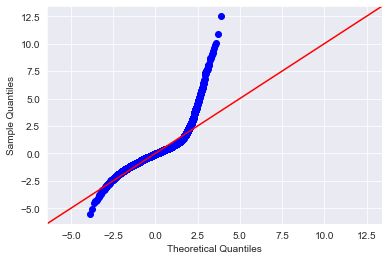

In [77]:
fig = sm.graphics.qqplot(model.resid, dist='norm', line='45', fit=True)

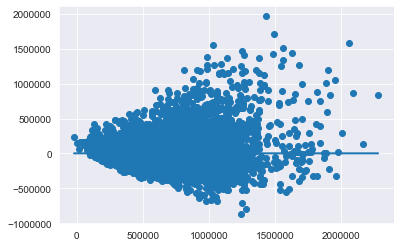

In [78]:
plt.scatter(model.predict(fin_x), model.resid)
plt.plot(model.predict(fin_x), [0 for i in range(len(final))])

# Log Transformation of Price 
Testing out model performance after performing log transformation on target variable 'price'

In [79]:
final['price'] = final['price'].map(lambda x : np.log(x))

In [80]:
final = final.rename({'price':'log_price'}, axis=1)

In [81]:
# remodeling
target = 'log_price'

feats = fin_x.columns

preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=final).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
======================================================================================
Model:                     OLS                    Adj. R-squared:           0.777     
Dependent Variable:        log_price              AIC:                      -1301.4617
Date:                      2020-07-31 11:46       BIC:                      -1048.0941
No. Observations:          20287                  Log-Likelihood:           682.73    
Df Model:                  31                     F-statistic:              2286.     
Df Residuals:              20255                  Prob (F-statistic):       0.00      
R-squared:                 0.778                  Scale:                    0.054825  
--------------------------------------------------------------------------------------
                                    Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
--------------------------------------------------------------------------------------
Intercept                          -35.5892   2.5978 -13.6998 0.0000 -40.6810 -30.4973
grd_6_to_7                          -0.1471   0.0047 -31.5767 0.0000  -0.1563  -0.1380
grd_10_to_11                         0.1845   0.0087  21.2021 0.0000   0.1675   0.2016
quad_1                               0.3547   0.0071  49.6359 0.0000   0.3407   0.3687
log_sqft_above                       0.1108   0.0061  18.3056 0.0000   0.0990   0.1227
has_basement                         0.0394   0.0077   5.0872 0.0000   0.0242   0.0545
waterfront_Y                         0.5504   0.0235  23.3863 0.0000   0.5042   0.5965
yr_built                            -0.0027   0.0001 -30.8054 0.0000  -0.0028  -0.0025
viewed                               0.1408   0.0065  21.7441 0.0000   0.1281   0.1535
grd_12_to_13                         0.3399   0.0403   8.4434 0.0000   0.2610   0.4188
log_sqft_living15                    0.0859   0.0028  30.6328 0.0000   0.0804   0.0914
bathrooms                            0.0136   0.0011  12.8556 0.0000   0.0115   0.0157
cond_average                        -0.0610   0.0042 -14.5682 0.0000  -0.0692  -0.0528
lat                                  0.5177   0.0231  22.4606 0.0000   0.4725   0.5629
log_sqft_lot15                      -0.0259   0.0023 -11.1513 0.0000  -0.0304  -0.0213
zipcode                             -0.0014   0.0001 -12.2330 0.0000  -0.0016  -0.0011
cond_very_good                       0.0598   0.0068   8.8255 0.0000   0.0465   0.0731
day_of_year                         -0.0002   0.0000 -10.3613 0.0000  -0.0002  -0.0001
long                                -0.1966   0.0191 -10.2942 0.0000  -0.2340  -0.1591
quad_4                               0.3299   0.0198  16.6686 0.0000   0.2911   0.3687
quad_2                               0.2662   0.0152  17.4831 0.0000   0.2363   0.2960
grd_1_to_5                          -0.3353   0.0170 -19.6772 0.0000  -0.3687  -0.3019
bedrooms                            -0.0235   0.0026  -9.0024 0.0000  -0.0286  -0.0184
is_renovated                         0.0187   0.0041   4.5965 0.0000   0.0107   0.0267
floors_2                             0.0162   0.0049   3.2805 0.0010   0.0065   0.0258
log_total_home_sqft                  0.0806   0.0081   9.9986 0.0000   0.0648   0.0964
floors_3                             0.0568   0.0110   5.1529 0.0000   0.0352   0.0784
cond_fair                           -0.1925   0.0198  -9.7096 0.0000  -0.2314  -0.1537
cond_poor                           -0.2879   0.0455  -6.3277 0.0000  -0.3770  -0.1987
log_sqft_above:log_total_home_sqft   0.0184   0.0026   6.9529 0.0000   0.0132   0.0236
bathrooms:log_total_home_sqft        0.0013   0.0009   1.4682 0.1421  -0.0004   0.0031
quad_1:log_sqft_above                0.0109   0.0039   2.7726 0.0056   0.0032   0.0186
--------------------------------------------------------------------------------------
Omnibus:                    446.328             Durbin-Watson:  

In [82]:
x_cols = fin_x
y = final['log_price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [83]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [84]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.054426718760804786
Test Mean Squarred Error: 0.0556605377333133


## Calculating Price in Terms of Dollars

In [89]:
# inversing the Log transformation on predictions vs. actual to compare RMSE
real_y_hat_test = np.exp(y_hat_test)
real_y_test = np.exp(y_test)

In [90]:
mse_test = np.sum((real_y_test - real_y_hat_test)**2)/len(real_y_test)
round(np.sqrt(mse_test),2)

148283.34

Our RMSE with the log transformation on price has dropped considerably.  The model is capable of predicting a house price within $148,000.  

Let's look at the QQ-plot and check for homoscedasticity.

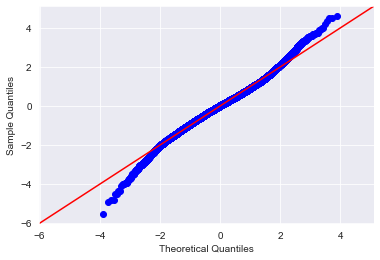

In [87]:
# Checking the residual errors
fig = sm.graphics.qqplot(model.resid, dist='norm', line='45', fit=True)

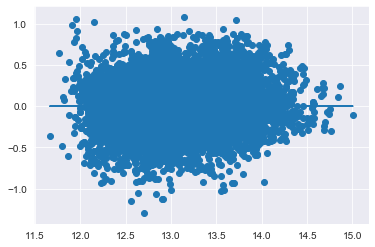

In [88]:
plt.scatter(model.predict(fin_x), model.resid)
plt.plot(model.predict(fin_x), [0 for i in range(len(final))])

# Analysis

According to the model, the following variables have the strongest impact on a home's price in King County:

* The grade that King County gave the home, especially if it was above a 9. This is a separate grading system established by King County that is separate from the condition of the home.  

* Location. Specifically whether or not you live in Quadrant 1, the Bellevue area.

* Whether or not you live on the waterfront.  Aside from paying to have a beautiful view, this could also be because most of the waterfront property is in the northeast section of King County (Quadrant 1). Strangely though, this appears to have a negative effect on the price, with a slope of -1 million.

This model still has a long way to go.  It is consistent, but there are still too many outliers and the residuals are not adhering to the assumptions of normality.  

In its current state, the model is only acceptable for estimating the more expensive homes in King County.